In [232]:
import kaggle
import pandas as pd
import numpy as np
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import torch

from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
def fetch_data():
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('fournierp/captcha-version-2-images', path=r'dataset', unzip=True)
fetch_data()

In [335]:
# setup 
batch_size_train = 32
batch_size_test = 135

random_seed = 1
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [227]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    ax.imshow(image, cmap = 'gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [228]:
 for item in os.listdir("./dataset/samples"):
        assert len(item) == 9

In [56]:
# tokenize
alphabet = "abcdefghijklmnopqrstuvwxyz"
numbers=map(str, list(range(0,10)))

tokens = list(alphabet + alphabet.upper()) + list(numbers)
n_tokens = len(tokens)
print(n_tokens)
token_dict = {i: tokens[i] for i in range(len(tokens))}
token_dict_reversed = {v: k for k, v in token_dict.items()}
print(token_dict_reversed)


62
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '0': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61}


In [210]:
class CAPTCHADataset(torch.utils.data.Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        
        # store the name of the image as that is the target/label
        self.targets = []
        self.paths = []

        images_path = self.path + "/"
        self.images = os.listdir(images_path)
        self.images.sort()
        for i in self.images:
            self.targets.append(i[:5])
            self.paths.append(images_path + i)
    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        """
        idx: Index of the image
        Return: dictionary of the image tensor and target tensor
        """
        img = cv2.imread(self.paths[idx])
        name = self.targets[idx]
        label = [token_dict_reversed[char] for char in name]
        
        # convert to onehot vector matrix
        label_onehot = []
        for ind in label:
            oh_vector = torch.zeros(n_tokens)
            oh_vector[ind] = 1
            label_onehot.append(oh_vector.unsqueeze(0))
            
        #print(img.shape)    
       
        # apply transformations to the image 
        if self.transforms:
            img = self.transforms(img)
            
        sample = {"image": img, "label": torch.cat(label_onehot)}
        
        return img, torch.cat(label_onehot)
        

In [211]:
# testing
label = [token_dict_reversed[char] for char in "3nw7w"]
label_onehot = []
for ind in label:
    oh_vector = torch.zeros(n_tokens)
    oh_vector[ind] = 1
    label_onehot.append(oh_vector.unsqueeze(0))
print(torch.cat(label_onehot))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [221]:
# do random split ~ 75% train, 12.5% for validation and test set
from torch.utils.data import random_split
def getDataLoaders(transform=None):
    # load data set
    
    
    dataset =  CAPTCHADataset("./dataset/samples", transforms = transform)
    captcha_training_set, captcha_validation_set = random_split(dataset, [800, 1070-800])
    captcha_validation_set, captcha_test_set = random_split(captcha_validation_set, [135, 135])
    
    
    train_loader = torch.utils.data.DataLoader(captcha_training_set, batch_size=batch_size_train, shuffle=True)

    validation_loader = torch.utils.data.DataLoader(captcha_validation_set, batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(captcha_test_set, batch_size=batch_size_test, shuffle=True)
    
    return train_loader, validation_loader, test_loader

transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((256,256)),
         transforms.Normalize((0.1307,), (0.3081,))
        ]
    )

train_loader, validation_loader, test_loader = getDataLoaders(transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 256, 256])
torch.Size([32, 5, 62])
torch.Size([3, 256, 256])


<Axes: >

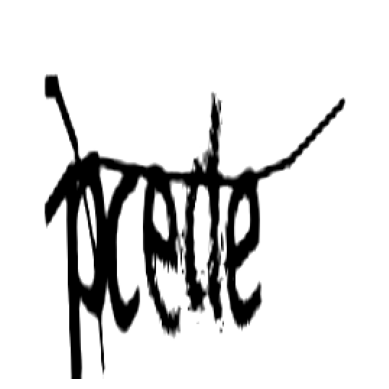

In [231]:
# check a sample
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)
print(example_data[0].unsqueeze(0)[0].shape)
imshow(example_data[0].unsqueeze(0)[0])

## Model Architecture

In [388]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_feature_maps = {
            "conv1": 6,
            "conv2": 12,
            "conv3": 18,
            "conv4": 24,
            "conv5": 32
        }
    
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, num_feature_maps['conv1'], kernel_size=3),
            nn.BatchNorm2d(num_feature_maps['conv1']),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(num_feature_maps['conv1'], num_feature_maps['conv2'], kernel_size=3),
            nn.BatchNorm2d(num_feature_maps['conv2']),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(num_feature_maps['conv2'], num_feature_maps['conv3'], kernel_size=5),
            nn.BatchNorm2d(num_feature_maps['conv3']),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(num_feature_maps['conv3'], num_feature_maps['conv4'], kernel_size=5),
            nn.BatchNorm2d(num_feature_maps['conv4']),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(num_feature_maps['conv4'], num_feature_maps['conv5'], kernel_size=5),
            nn.BatchNorm2d(num_feature_maps['conv5']),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(512, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(100, 62),
            nn.BatchNorm1d(62)
        )
        
        
    def forward(self, x):
        """
        Forward for network
        input: x: pytorch tensor of size [Batchsize, 3, 256, 256]
        returns: pytorch tensor of size [32, 62]
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # fully connected part
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        # final activation via softmax
        x = F.softmax(x, dim = 1)
        return x

### Calculate the input size of the fully connected network

In [355]:
def calculate_fc_inputsize(image_size:int, 
                           filter_sizes:list, 
                           max_pool_sizes:list, 
                           final_layer_feature_maps:int,
                           print_ = False
                          ):
    """
    Assumes stride=1 for kernels and stride=2 for maxpooling layers
    """
    conv = image_size
    for i in range(0, len(filter_sizes)):
        conv = conv - filter_sizes[i] + 1
        conv = (conv - max_pool_sizes[i] + 2) //2
        if print_:
            print("Convolution {} output size: {}**2".format(i, conv))
    return (conv**2)*final_layer_feature_maps

calculate_fc_inputsize(256, [3,3,5,5,5], [2,3,2,3,2], 32, print_=True)

Convolution 0 output size: 127**2
Convolution 1 output size: 62**2
Convolution 2 output size: 29**2
Convolution 3 output size: 12**2
Convolution 4 output size: 4**2


512

### Check forward pass for an image

In [389]:
random_seed = 1
torch.manual_seed(random_seed)
with torch.no_grad():
    model = Net()
    x = example_data
    print(x.shape)
    output = model(x)
    print(output.shape)
    print(output)

torch.Size([32, 3, 256, 256])
torch.Size([32, 62])
tensor([[0.0068, 0.0055, 0.0263,  ..., 0.0158, 0.0128, 0.0157],
        [0.0059, 0.0024, 0.0148,  ..., 0.0072, 0.0422, 0.0923],
        [0.0113, 0.0068, 0.0246,  ..., 0.0181, 0.0052, 0.0163],
        ...,
        [0.0255, 0.0190, 0.0203,  ..., 0.0307, 0.0058, 0.0134],
        [0.0183, 0.0279, 0.0386,  ..., 0.0125, 0.0277, 0.0038],
        [0.0053, 0.0064, 0.0058,  ..., 0.0120, 0.0043, 0.0056]])


In [404]:
example_output = torch.topk(output, 5, dim=1)[1][0]

label_onehot = []
for ind in example_output:
    oh_vector = torch.zeros(n_tokens)
    oh_vector[ind] = 1
    label_onehot.append(oh_vector.unsqueeze(0))
output_oh = torch.cat(label_onehot)
print(output_oh)

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [406]:
F.cross_entropy(example_targets[0], output_oh)

tensor(4.1545)

In [ ]:
class Trainer:
    def __init__(self):
        pass
    def train(self):
        pass
    def validation(self):
        pass